In [1]:

from frugal_flows.causal_flows import (train_frugal_flow, 
                                        train_copula_flow, 
                                        get_independent_quantiles, 
                                        univariate_discrete_cdf,
                                        independent_continuous_marginal_flow)

from frugal_flows.sample_marginals import from_quantiles_to_marginal_discr, from_quantiles_to_marginal_cont

from flowjax.distributions import AbstractDistribution #Transformed, Uniform, _StandardUniform


import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import optax
from flowjax.bijections import (
    Affine,
    Concatenate,
    Invert,
    RationalQuadraticSpline,
    Stack,
    Tanh,
)
from flowjax.bijections.utils import Identity
from flowjax.distributions import Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.utils import get_ravelled_pytree_constructor
from flowjax.wrappers import NonTrainable
from jaxtyping import ArrayLike
from jax import Array
from functools import partial

SEED = 0

jax.config.update("jax_enable_x64", True)

In [2]:
# DEPENDENT Zs
n_samples = 5000
key, subkey = jr.split(jr.PRNGKey(SEED))
# continuous z
z = jr.multivariate_normal(key, jnp.array([0.,0.,0.]), jnp.array([[1., 0.8, 0.8],[0.8, 1.,0.8], [0.8, 0.8, 1.0]]), shape=(n_samples,))

In [3]:
z_cont = z[:,:2]

In [4]:
u_z_discr = jax.scipy.stats.norm.cdf(z[:,2])

In [5]:
z_discr_cdf = jnp.array([0.2, 0.6, 1.])

In [6]:
z_discr = jnp.digitize(u_z_discr, jnp.hstack([jnp.array(0.), z_discr_cdf]))-1

# Continuous case

In [7]:
# RQS_knots = 8
# flow_layers = 8
# nn_width= 50
# nn_depth = 1
# show_progress= True
# learning_rate = 5e-4
# max_epochs = 100
# max_patience = 5
# batch_size= 100
# val_prop = 0.1

In [8]:
res = get_independent_quantiles(key = jr.PRNGKey(3),
                                z_discr=jnp.vstack([z_discr,z_discr]).T, #jnp.expand_dims(z_discr,axis=1), #impose discrete
                                z_cont=z_cont,
                                max_epochs = 70,
                                max_patience=10,
                                return_z_cont_flow = True,
                             )

 79%|████████████████████████████████████████████████████████████████████████████████▉                      | 55/70 [00:07<00:02,  7.43it/s, train=1.4124502326111266, val=1.450246689556133 (Max patience reached)]


In [24]:
plt.scatter(y=marginal_samples_cont[:, 0], x=marginal_samples_cont[:, 1])

Array([[0.53524499, 0.95454151],
       [0.72700887, 0.61925485],
       [0.73335438, 0.04638613],
       ...,
       [0.90049308, 0.09848333],
       [0.67623566, 0.46068684],
       [0.68959124, 0.51062326]], dtype=float64)

In [31]:
jax.scipy.special.ndtri(z[:, :2])[:N_samples, :]

Array([[        nan,         nan],
       [        nan,         nan],
       [-0.14162156, -1.98093749],
       ...,
       [        nan,  0.67544094],
       [        nan,         nan],
       [        nan, -3.3723141 ]], dtype=float64)

In [32]:
N_samples = 1000
u_z = jr.uniform(jr.PRNGKey(8), (N_samples,2))
u_z = jax.scipy.special.ndtr(z[:, :2])[:N_samples, :]
marginal_samples_cont = from_quantiles_to_marginal_cont(key= jr.PRNGKey(8),
                                    flow=res['z_cont_flows'],
                                    u_z=u_z,
                                   n_samples=N_samples)

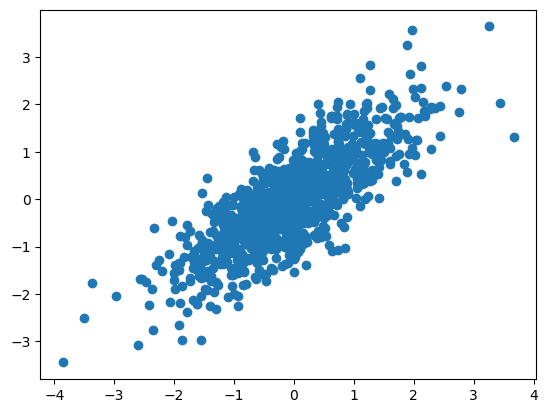

In [33]:
import matplotlib.pyplot as plt
plt.scatter(y=marginal_samples_cont[:, 0], x=marginal_samples_cont[:, 1])

In [11]:
marginal_samples_cont.shape

(100, 2)

In [12]:
marginal_samples_discr = from_quantiles_to_marginal_discr(key=key,
                                    mappings=res['z_discr_rank_mapping'],
                                    nvars=res['u_z_discr'].shape[1],
                                    empirical_cdfs=res['z_discr_empirical_cdf_long'],
                                    u_z=u_z,
                                   n_samples=N_samples)

In [13]:
marginal_samples_discr.shape

(100, 2)